In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy import genfromtxt
from sklearn.cluster import KMeans  # used in Algorithm 1 (Spectral Graph Partitioning)

### Prepare the paraboloid input data

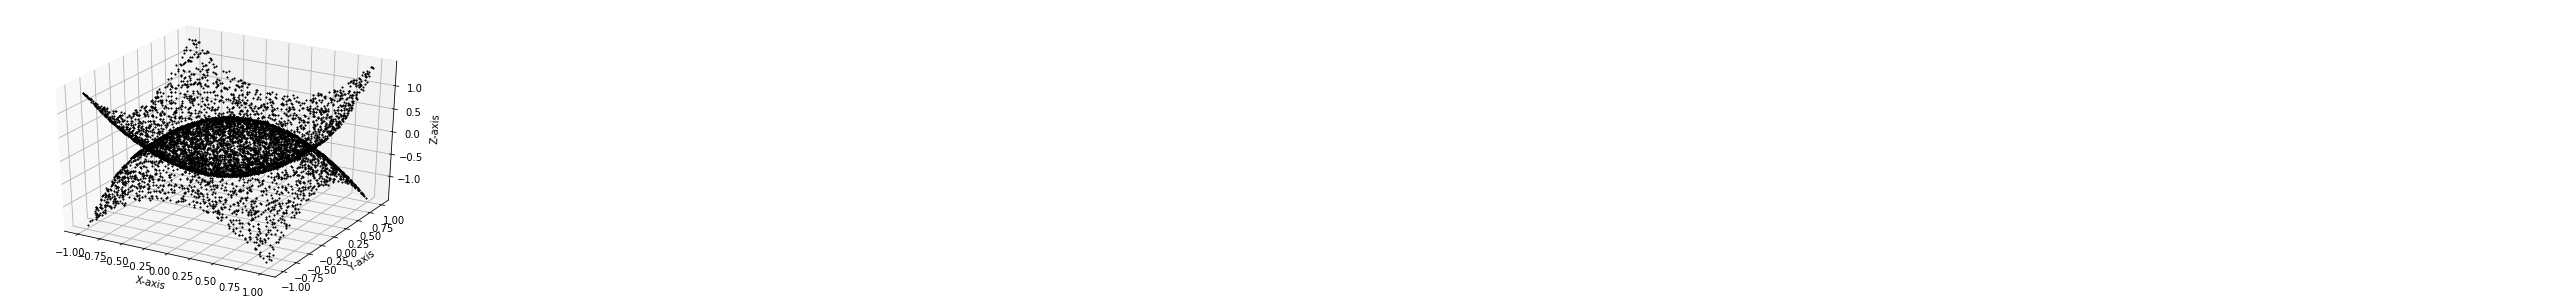

In [2]:
np.random.seed(0)
N_half = 4000
bandwidth = 0.01

X1 = np.random.uniform(-1.0, 1.0, N_half) + np.random.uniform(-bandwidth, bandwidth, N_half)
Y1 = np.random.uniform(-1.0, 1.0, N_half) + np.random.uniform(-bandwidth, bandwidth, N_half)
X2 = np.random.uniform(-1.0, 1.0, N_half) + np.random.uniform(-bandwidth, bandwidth, N_half)
Y2 = np.random.uniform(-1.0, 1.0, N_half) + np.random.uniform(-bandwidth, bandwidth, N_half)

paraboloid_data1 = np.array([ X1,  Y1,   X1 * X1 + Y1 * Y1 - 0.5 ]).T

paraboloid_data2 = np.array([ X2,  Y2,  - (X2 * X2 + Y2 * Y2 - 0.5) ]).T

paraboloid_input_data = np.concatenate([paraboloid_data1, paraboloid_data2], axis=0)
n = 2 * N_half
rnd_idx = np.random.choice(n, n, replace=False)
paraboloid_input_data =paraboloid_input_data[rnd_idx, :]

# Visualize
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

ax.plot(paraboloid_input_data[:,0], paraboloid_input_data[:,1], paraboloid_input_data[:,2], ".", color="black", ms=3, mew=0.5)
plt.show()

### Prepare the sphere input data

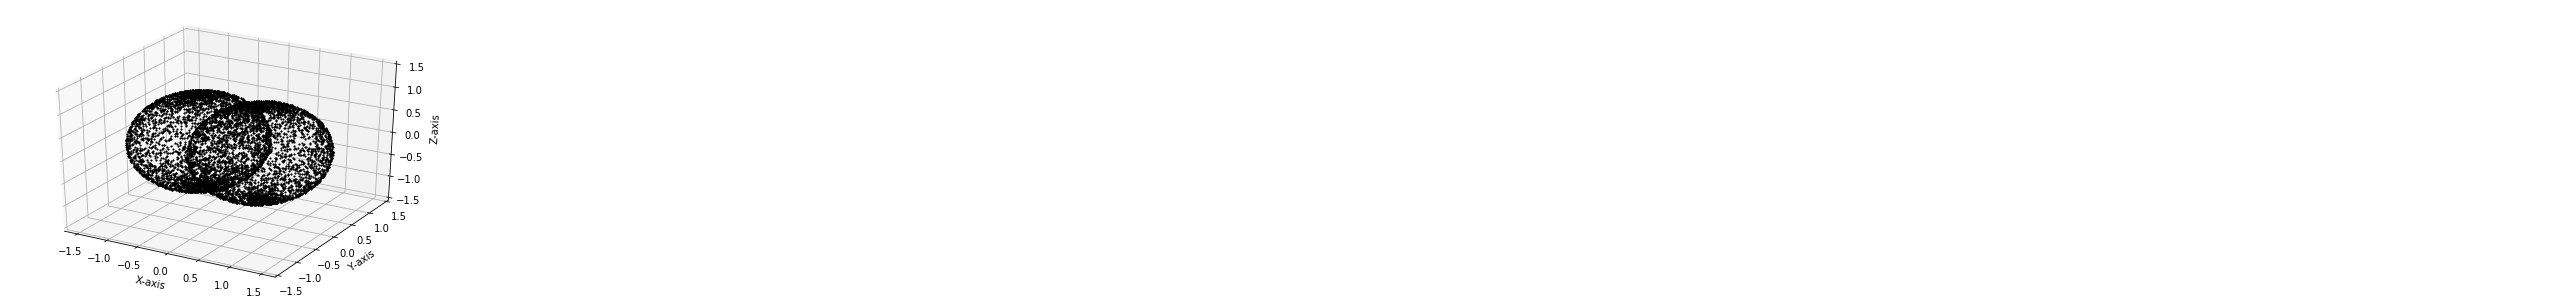

In [3]:
np.random.seed(0)
N_half = 4000

theta1 = np.random.uniform(0.0, math.pi, N_half)
phi1 = np.random.uniform(-math.pi, math.pi, N_half)
radius1 = 1 + np.random.uniform(- 0.001, 0.001, N_half)
theta2 = np.random.uniform(0.0, math.pi, N_half)
phi2 = np.random.uniform(-math.pi, math.pi, N_half)
radius2 = 1 + np.random.uniform(- 0.001, 0.001, N_half)

sphere_data1 = np.array([
                    0.5 + radius1 * np.sin(theta1) * np.cos(phi1),
                    radius1 * np.sin(theta1) * np.sin(phi1),
                    radius1 * np.cos(theta1)
                ]).T
sphere_data2 = np.array([
                    - 0.5 + radius2 * np.sin(theta2) * np.cos(phi2),
                    radius2 * np.sin(theta2) * np.sin(phi2),
                    radius2 * np.cos(theta2)
                ]).T

sphere_input_data = np.concatenate([sphere_data1, sphere_data2], axis=0)
n = 2 * N_half
rnd_idx = np.random.choice(n, n, replace=False)
sphere_input_data = sphere_input_data[rnd_idx, :]

# Visualize
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

ax.plot(sphere_input_data[:,0], sphere_input_data[:,1], sphere_input_data[:,2], ".", color="black", ms=3, mew=0.5)
plt.show()

### Main Algorithm

In [4]:
# Algorithm 1 (Spectral Graph Partitioning) in the paper, which is used in Algorithm 4 ********
def SpectralGraphPartitioning(W, K):
    '''
    ***Input***
    W: float, 2d-array (N * N, where N is the number of data point)
        Affinity matrix
    K: int
        The number of clusters

    ***Return***
    kmeans.labels_: int, 1d-array (with length N)
        The labels of each data point
    '''
    W_rowsum = W.sum(axis=1)
    Z = W / np.sqrt(np.outer(W_rowsum, W_rowsum)) # Step 1, Compute Z
    eigen_value, eigen_vector = np.linalg.eig(Z)
    top_index = eigen_value.argsort()[::-1][0:K]
    out_matrix = eigen_vector[:, top_index]       # Step 2, Extract the top K eigenvectors of Z
    # Step 3, Renormalize each row of the resulting n * K matrix
    out_matrix = out_matrix / np.c_[np.linalg.norm(out_matrix, axis=1)]
    # Step 4, Apply K-means to the row vector
    kmeans = KMeans(n_clusters=K, random_state=0).fit(out_matrix)
    return kmeans.labels_

# Algorithm 4 (main algorithm) ****************************************************************
def spectral_clustering_lpca(input_data, r, eps, eta, d, K):
    '''
    ***Input***
    input_data:

    r: float
        neighborhood radius parameter, r > 0.
    eps: float
        spatial scale parameter, eps > 0.
    eta: float
        projection scale parameter, eps > 0.
    d: int
        intrinsic dimension, d >= 1.
    K: int
        number of clusters, K >= 2.

    ***Return***
    result_data: float, 2d-array (n * 3, where n is the number of "black pixels" of the input figure)
        Each row corresponds to each pixel of the input figure.
        Each row data means [ x-coordinate, y-coordinate, label ].
    '''
    np.random.seed(0)
    n = len(input_data)
    ramaining_index_list = list(range(n))
    full_index_list = list(range(n))

    N_y_list = []

    # 1st and 2nd Step: Creates y_i, N(y_i), C_i, Q_i
    while ramaining_index_list:
        y_seed_num = np.random.choice(ramaining_index_list)  # Pick up y_i's index randomly
        ramaining_index_list.remove(y_seed_num)  # Remove y_i's index form the residual list
        y_i = input_data[y_seed_num]  # Get y_i

        N_y_i_list = list(
            [i for i in full_index_list if np.linalg.norm(input_data[i] - y_i) < r])  # Get N(y_i)'s index
        N_y_i = input_data[N_y_i_list]  # Get N(y_i)
        N_y_i = np.concatenate([N_y_i, y_i.reshape(1, 3)], axis=0)  # Merge y_i and N(y_i)

        number_set = set(ramaining_index_list) - set(N_y_i_list)
        ramaining_index_list = list(number_set)  # Remove N(y_i)'s index form the residual list

        N_y_i_list.append(y_seed_num)  # Merge y_i's index and N(y_i)'s index

        C = np.cov(N_y_i, rowvar=0, bias=0)  # Covariance Matrix for N(y_i)

        eigen_value, eigen_vector = np.linalg.eig(C)
        top_index = eigen_value.argsort()[::-1][0:d]
        P = eigen_vector[:, top_index]  # P is a matrix whose columns are the top d eigenvectors of C
        Q = np.dot(P, P.T)              # Get the orthogonal projection matrix

        # intermediate output about N(y_i)
        N_y_list.append([y_i,
                         N_y_i_list,
                         N_y_i,
                         C,
                         Q])

    # 3rd Step: Compute the following affinities W_ij
    n0 = len(N_y_list)
    W = np.zeros([n0, n0])
    for i in range(n0):
        for j in range(n0):
            # Note N_y_list[i][0] is y_i and N_y_list[i][4] is Q_i, created above.
            # Note the first norm is a vector norm and the second is a matrix norm.
            W[i][j] = np.exp(-np.linalg.norm(N_y_list[i][0] - N_y_list[j][0]) ** 2 / eps ** 2) \
                      * np.exp(-np.linalg.norm(N_y_list[i][4] - N_y_list[j][4]) ** 2 / eta ** 2)

    # 4th Step: Use algorithm 1 (Spectral Graph Partitioning) for W
    y_class = SpectralGraphPartitioning(W=W, K=K)

    # Create y array to prepare for the next calculation to find the closest y_j
    y = np.empty((0, 3), float)
    for i in range(n0):
        y = np.append(y, np.r_[N_y_list[i][0]].reshape(1, 3), axis=0)

    # 5th Step: For all input data x_i, find the closest y_j
    result_data = np.empty((0, 4), float)
    for i in range(n):
        min_index = np.argmin(np.linalg.norm(y - np.r_[input_data[i]], axis=1))
        result_data = np.append(result_data, [[input_data[i][0], input_data[i][1], input_data[i][2],  y_class[min_index]]], axis=0)

    return result_data

### Paraboloid result

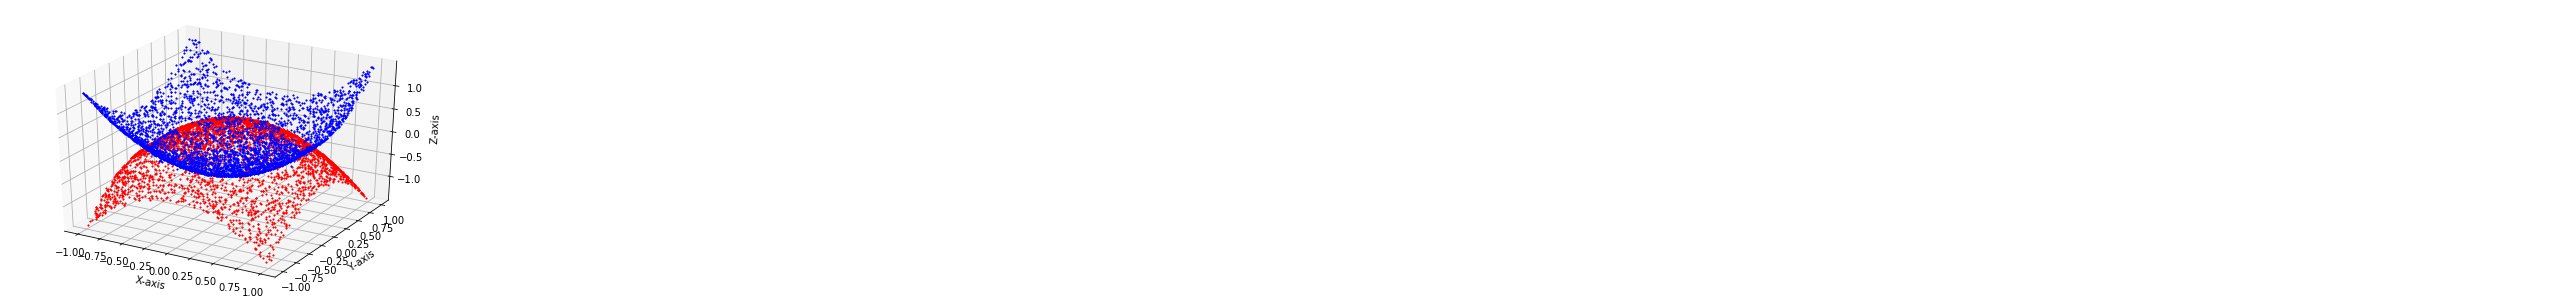

In [5]:
# Call Algorithm 4
r = 0.1
eps = 0.1
eta = 0.5
d = 2
K = 2
paraboloid_result = spectral_clustering_lpca(input_data=paraboloid_input_data, r=r, eps=eps, eta=eta, d=d, K=K)

# Visualize
fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

d1 = paraboloid_result[paraboloid_result[:,3] == 0]
d2 = paraboloid_result[paraboloid_result[:,3] == 1]
ax.plot(d1[:,0], d1[:,1], d1[:,2], ".", color="red", ms=3, mew=0.5)
ax.plot(d2[:,0], d2[:,1], d2[:,2], ".", color="blue", ms=3, mew=0.5)
plt.show()

### Sphere result

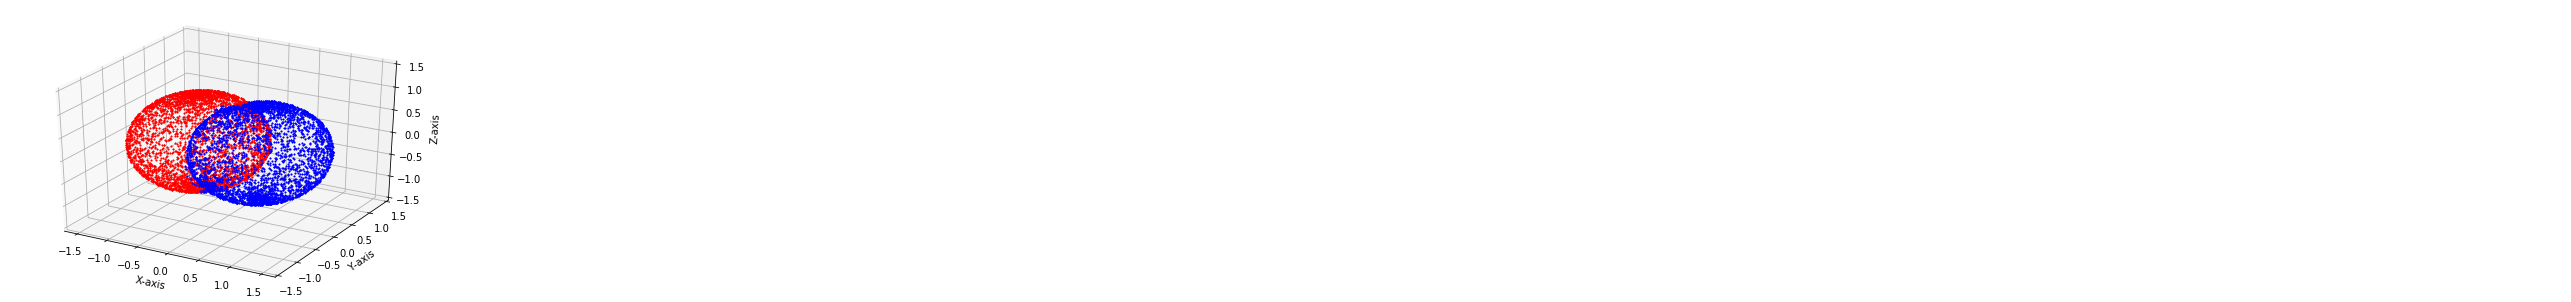

In [6]:
# Call Algorithm 4
r = 0.2
eps = 0.2
eta = 0.5
d = 2
K = 2
sphere_result = spectral_clustering_lpca(input_data=sphere_input_data, r=r, eps=eps, eta=eta, d=d, K=K)

fig = plt.figure()
ax = Axes3D(fig)
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

d1 = sphere_result[sphere_result[:,3] == 0]
d2 = sphere_result[sphere_result[:,3] == 1]

ax.plot(d1[:,0], d1[:,1], d1[:,2], ".", color="red", ms=3, mew=0.5)
ax.plot(d2[:,0], d2[:,1], d2[:,2], ".", color="blue", ms=3, mew=0.5)
plt.show()